參考資料：

教材網頁：
+ https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/?fbclid=IwAR2hFMfTqG7ielGSfrtzEbUIH7EPXNOLG3dIQidMwiOh-wISSWL-sYf8Yhg

In [1]:
# 查看notebook運行環境
!nvidia-smi

Thu Dec  9 06:27:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.00    Driver Version: 470.82.00    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 25%   33C    P8    19W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 24%   

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.8
IPython 7.16.2

numpy 1.19.5
pandas 1.1.5
torch 1.6.0
transformers 3.0.0


In [5]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
# 下載所需資料 reviews.csv
# !gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

In [8]:
df = pd.read_csv("reviews.csv")
print(f"資料筆數: {df.shape[0]}, 資料欄位: {df.shape[1]}")
df.head(3)

資料筆數: 15746, 資料欄位: 11


,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo


In [9]:
# 檢視資料基本資訊
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


觀察評論分數分布，發現除了分數3外，其他分數都分布的很平均

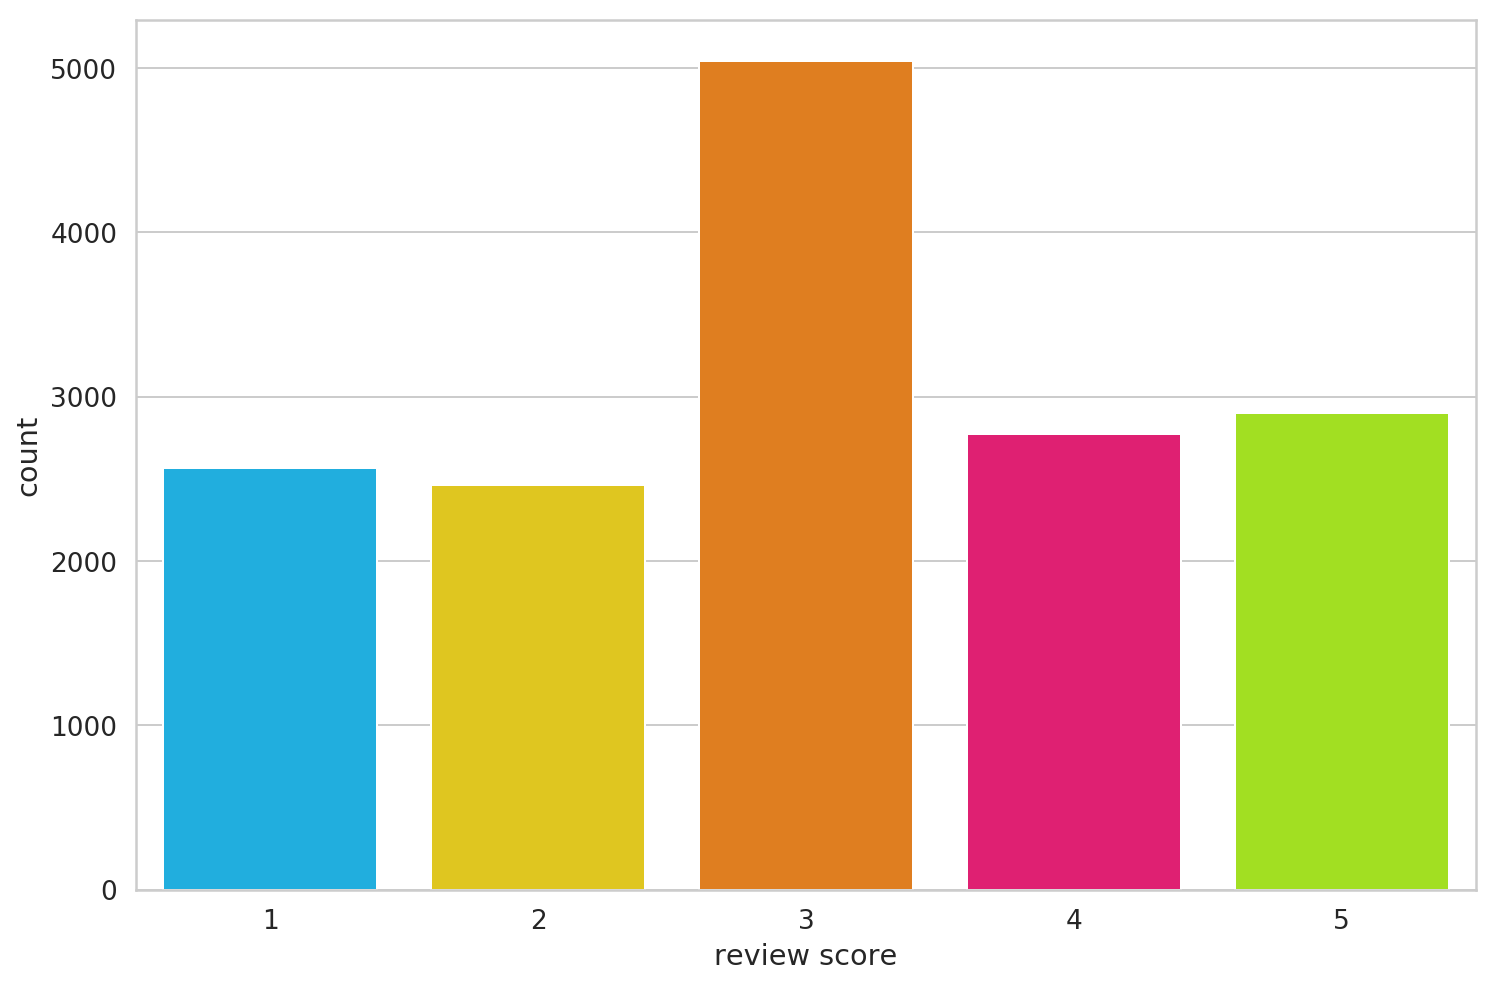

In [10]:
sns.countplot(df.score)
plt.xlabel('review score');

為了將評論分數分類，我們將分數小於2的評論分類為負面情緒；分數3的分類為中性情緒；分數超過三的分類為正面

In [11]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else: 
        return 2

df['sentiment'] = df.score.apply(to_sentiment)

我們將評論分數score轉換成sentiment欄位後，看一下各情緒的筆數分布

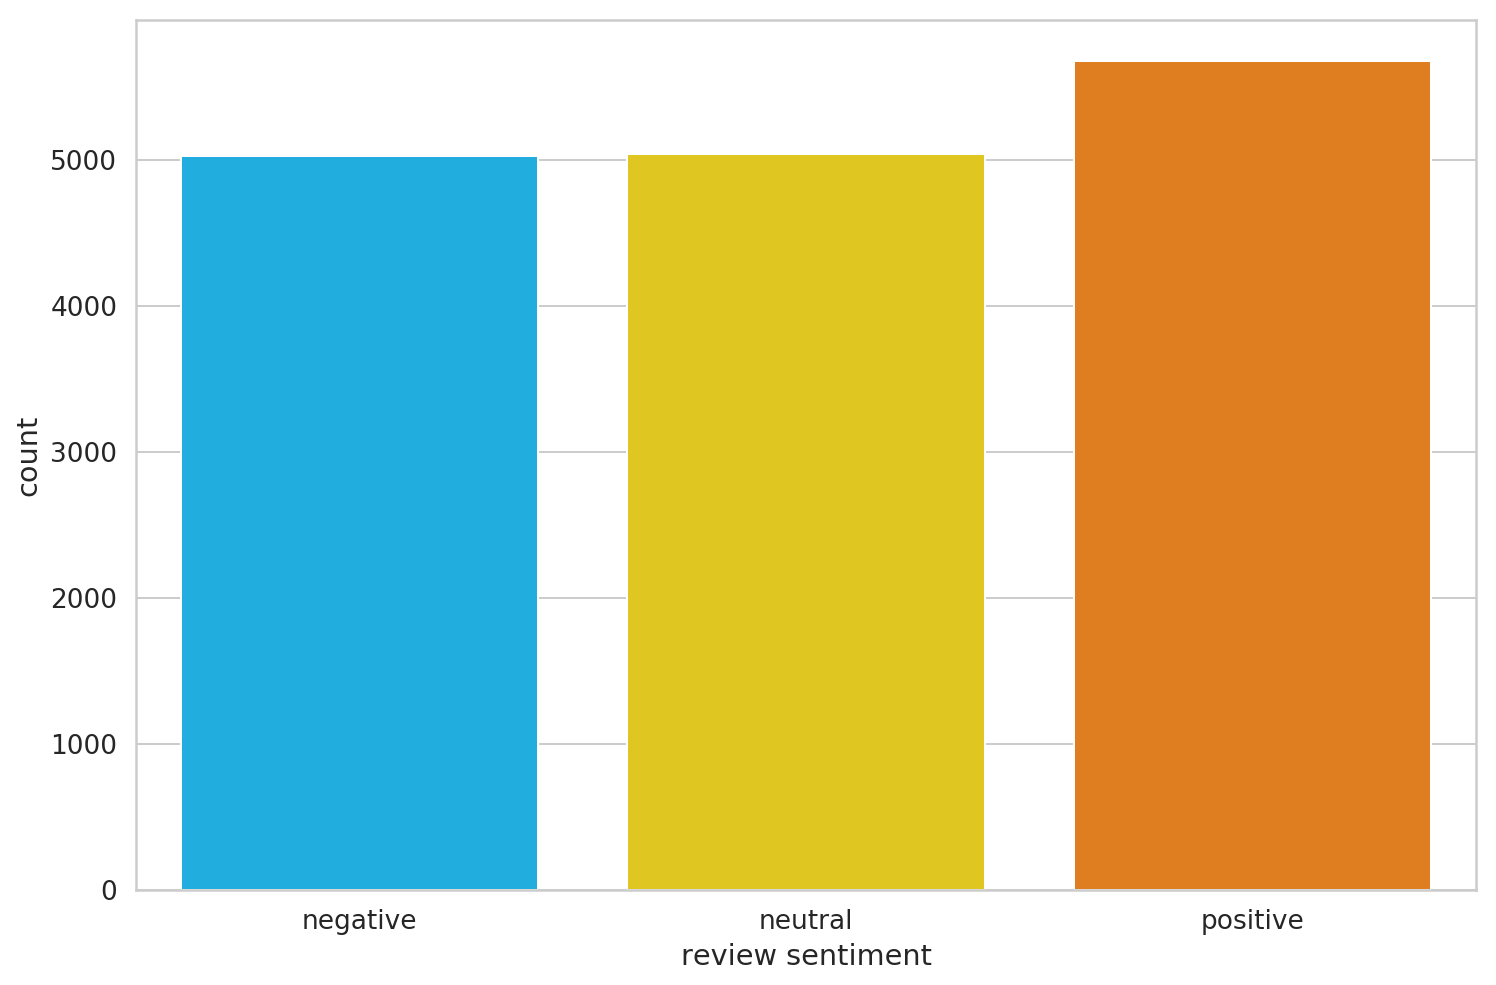

In [12]:
# 幫圖的x軸從左至右加上標籤
class_names = ['negative', 'neutral', 'positive']

# 畫圖
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

定義模型

統計完資料集後，我們接下來要定義模型的部分，因為BERT 訓練十分耗時，我們可以利用transformer已經訓練好的預訓練模型(pre-trained mdel)來做建模。
在這裡同學可以嘗試不同的預訓練模型，在這裡使用會區分大小寫的 bert-base-cased 模型，因為在情緒表達上，大寫通常代表比較強烈的情緒，如 GOOD 通常比good有更強烈的意思。

In [13]:
# 指定預訓練模型種類
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [14]:
# 定義 tokenizer (處理句子的模式)
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

tokenizer 例句示範
在將訓練資料丟入模型前，我們需要將資料處理成BERT可以理解的格式，以下用簡單的例子當作示範。

+ 字詞的ID
    + `tokenizer` 會斷開句子中的每個詞和符號，並標上預訓練字典中獨特的ID。在這裡我們可以看到因為我們用的是會區分大小寫的模型，所以兩個My和my的ID是不一樣的，另外兩個位置的friend，因為是同樣的字，會有同樣的ID。
+ 句子的特殊標記
    + `[CLS]`：加在每句話的開頭
    + `[SEP]`：加在每句話的結尾
    + `[PAD]`：句子中的間隔
    + `[UNK]`：代替預訓練資料集中沒有出現過的字

In [15]:
sample_txt = 'My my dear friend. Together friend forever.' # 範例句子
tokens = tokenizer.tokenize(sample_txt) # 切開的詞
token_ids = tokenizer.convert_tokens_to_ids(tokens) # 詞的ID

print(f'Sentence: {sample_txt}\n')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}\n')

# 查看tokenizer中的設定
print(f'start marker: {tokenizer.cls_token}, id {tokenizer.cls_token_id}')  # 句子的開頭
print(f'end marker: {tokenizer.sep_token}, id {tokenizer.sep_token_id}')  # 句子的結尾
print(f'padding marker: {tokenizer.pad_token}, id {tokenizer.pad_token_id}')  # padding
print(f'unknown marker: {tokenizer.unk_token}, id {tokenizer.unk_token_id}')  # 不知道的詞

Sentence: My my dear friend. Together friend forever.

Tokens: ['My', 'my', 'dear', 'friend', '.', 'Together', 'friend', 'forever', '.']
Token IDs: [1422, 1139, 7059, 1910, 119, 6333, 1910, 5221, 119]

start marker: [CLS], id 101
end marker: [SEP], id 102
padding marker: [PAD], id 0
unknown marker: [UNK], id 100


+ encode_plus
    + 可以利用 encode_plus 這個函數，直接將整個句子 encode
    + `max_length`: 一句話的最大長度，如果句子長度超過就會截斷，不足的話就用`[PAD]`補上
    + `add_special_tokens`：加上開頭和結尾標記
    + `return_token_type_ids`：回傳token id
    + `pad_to_max_length`：是否將pad增加至最大長度
    + `return_attention_mask`：回傳attention的結果
    + `return_tensors`：

In [16]:
encoding = tokenizer.encode_plus(
  sample_txt, # 我們上面定義的句子
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True, # False # True
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

# 可以將 encode 值取出來的key
print(f"type of encode: {type(encoding)}")
encoding.keys()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


type of encode: <class 'transformers.tokenization_utils_base.BatchEncoding'>


dict_keys(['input_ids', 'attention_mask'])

+ 查看encode之後的結果：
    + 用上面找到的`key`把encode之後的值取出來，如果句子長度不足`max_length`的地方會補0，有字的地方attention mask會是1，其餘是0

In [17]:
# 查看 encode之後的結果
print(f"{sample_txt}")
print(f"sentence length after encoding: {len(encoding['input_ids'][0])}\n") # encode後句子的長度

encode_tokenID = encoding['input_ids'][0]
encode_attention = encoding['attention_mask'][0]
encode_token = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]) # 將ID轉換回token

print(f"attention mask:\n {encode_tokenID}") # encode後的 token ID
print(f"attention tokens:\n {encode_token}") # encode後的 token 
print(f"attention mask:\n {encode_attention}") # encode後的 attention mask

My my dear friend. Together friend forever.
sentence length after encoding: 32

attention mask:
 tensor([ 101, 1422, 1139, 7059, 1910,  119, 6333, 1910, 5221,  119,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
attention tokens:
 ['[CLS]', 'My', 'my', 'dear', 'friend', '.', 'Together', 'friend', 'forever', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
attention mask:
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


在我們正式把資料轉換為BERT可以用的形式前，我們需要決定一個句子最大的長度該訂多少，我們先檢視一下資料及裡面句子的長度都是多少，將鋸子長度的分布畫出來之後，我們可以發現大部分的句子都集中在160個字左右，我們將max length訂為160。

In [18]:
# 計算資料集中句子的長度
token_lens = [] # 存所有句子的長度
for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True) # 將句子斷開，限定最大長度為512
    token_lens.append(len(tokens))

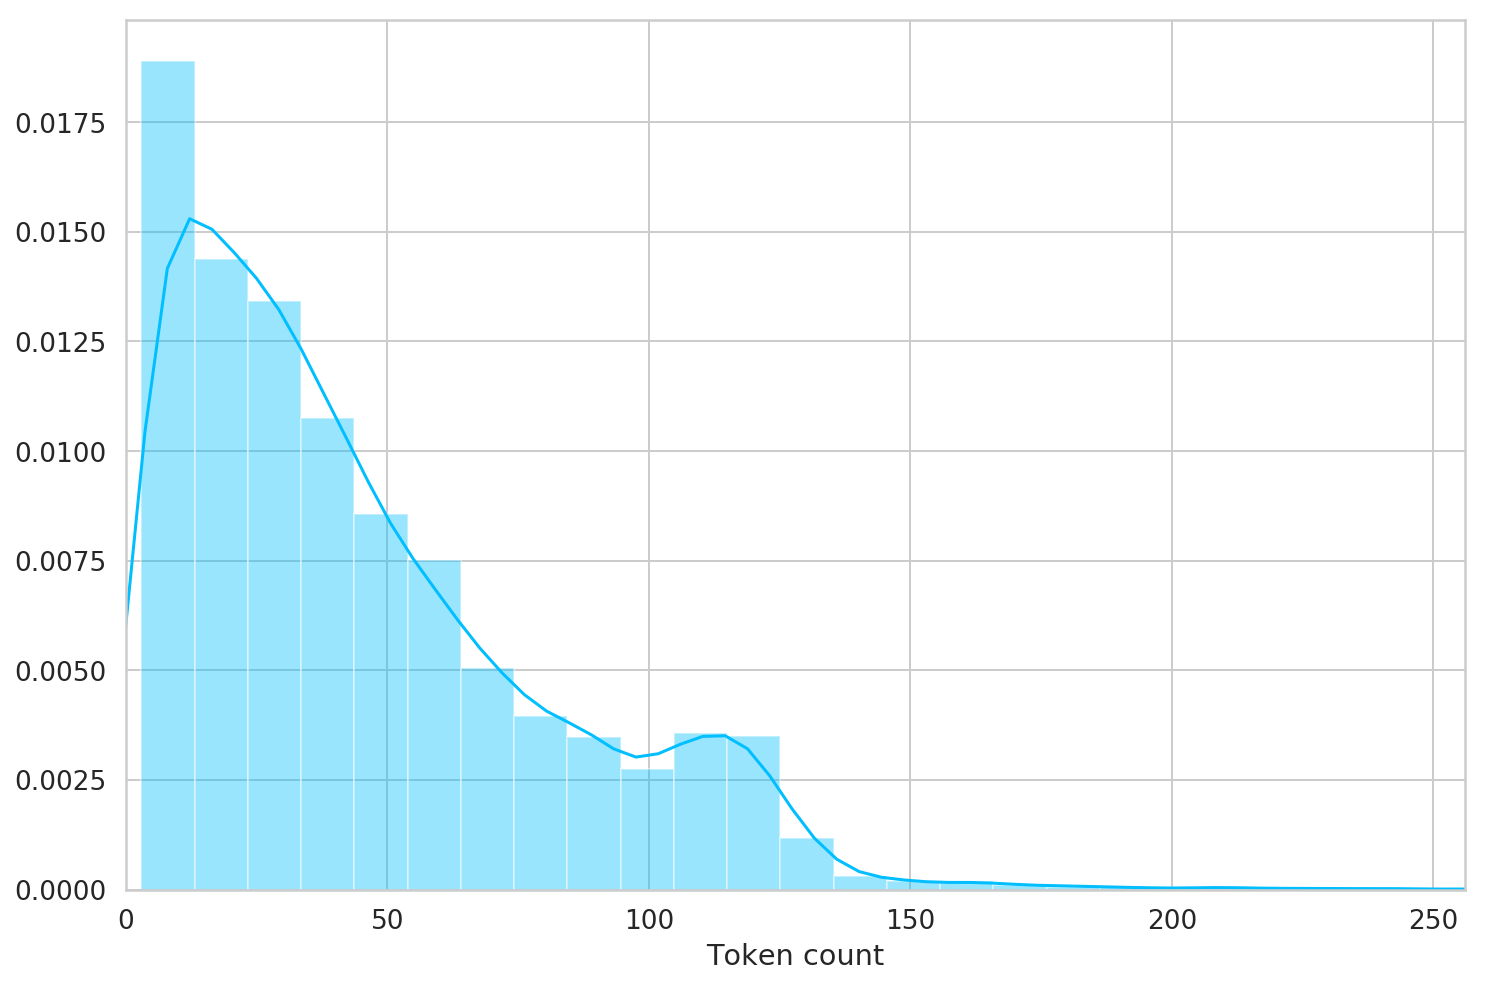

In [19]:
# 將句子長度的分布畫出來
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

將資料集依據9:1切成 train和test，再取出test的一半，切成validation。

In [20]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

# 看一下三種資料的總筆數
print("shape of train / validation / test")
print(df_train.shape, df_val.shape, df_test.shape)

shape of train / validation / test
(14171, 12) (787, 12) (788, 12)


+ 定義處理資料的物件和函數：
    + `GPReviewDataset`：encoding 句子，並把預測目標轉成torch.tensor
    + `create_data_loader`：指定傳入的資料集中，要encode的句子和預測目標的欄位。

In [21]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          truncation=True,
          add_special_tokens=True,
          max_length=self.max_len, #句子的最大長度
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(), # encode 完之後的 token id
          'attention_mask': encoding['attention_mask'].flatten(), # encode 完之後的 attention mask
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [22]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    # ds GPReviewDataset 處理後的回傳結果
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(), # 要預測的句子
        targets=df.sentiment.to_numpy(), # 要預測的目標
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

利用上面定義的 function 定義處理資料的物件，依據上面句子處理的結果，我們可以定義 `MAX_LEN`的長度。
+ `BATCH_SIZE`：一次更新要處理幾個句子
+ `MAX_LEN`：一個句子多長

In [23]:
BATCH_SIZE = 16 
MAX_LEN = 160

# 處理 train / validation / test 的 data loader
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

我們拿 train 的資料來看看處理完的結果，data裡的key就是剛才`GPReviewDataset`會return的結果。
+ `review_text`：要預測的句子
+ `input_ids`：句子中的 token ID
+ `attention_mask`：句子中要 attention 的位置
+ `targets`：預測的目標

In [24]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [25]:
# sahpe = (BATCH_SIZE * MAX_LEN)
print(data['input_ids'].shape)
print(data['attention_mask'].shape)

# sahpe = BATCH_SIZE
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## 定義要使用的BERT分類模型

這邊會從Transformers library上面下載最基本的 [Bert 模型](https://huggingface.co/transformers/model_doc/bert.html#bertmodel)，另外Transformers也提供針對特定任務設計的包裝好的model，可以參考以下的連結

+ 句子分類：[BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification)
+ QA任務：[BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering)

In [26]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # 上面定義的 'bert-base-cased'

我們拿剛剛的範例句子的encode結果(my my dear friend那句，套用到模型裡面看看會有甚麼結果)

In [27]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask']
)

print(f"{bert_model.config.hidden_size}")  # bert 用來代表每個字的維度
print(f"{last_hidden_state.shape}")  # bert model 最後一層 layer 的 sahpe
print(f"{pooled_output.shape}")  # 句子最後output的shape

768
torch.Size([1, 32, 768])
torch.Size([1, 768])


接下來我們定義一個完整的模型，把 BERT 後面再加上一層dropout，最後用linear的分類器把最後一層layer的hidden state拿去做分類。

In [28]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        # 定義會用到的方法
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # 最後一 層layer 的 sahpe, 要分成幾類
  
    def forward(self, input_ids, attention_mask):
        # 把上面定義的方法串起來
        _, pooled_output = self.bert( 
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        
        return self.out(output)

定義完模型後，我們用`.to(device)`把模型和訓練資料都移到GPU上面

In [29]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [30]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [31]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4167, 0.1629, 0.4204],
        [0.5268, 0.1343, 0.3389],
        [0.3120, 0.1510, 0.5370],
        [0.5324, 0.1180, 0.3496],
        [0.6053, 0.1680, 0.2267],
        [0.3334, 0.1828, 0.4838],
        [0.4221, 0.1138, 0.4641],
        [0.3167, 0.2619, 0.4215],
        [0.3325, 0.1465, 0.5211],
        [0.2637, 0.1996, 0.5367],
        [0.4092, 0.1467, 0.4441],
        [0.3765, 0.2127, 0.4107],
        [0.5731, 0.0732, 0.3537],
        [0.4752, 0.1724, 0.3525],
        [0.3837, 0.1831, 0.4332],
        [0.3463, 0.2110, 0.4427]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [32]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [33]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [34]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [35]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/test/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/local/anaconda3/envs/test/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/anaconda3/envs/test/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/anaconda3/envs/test/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

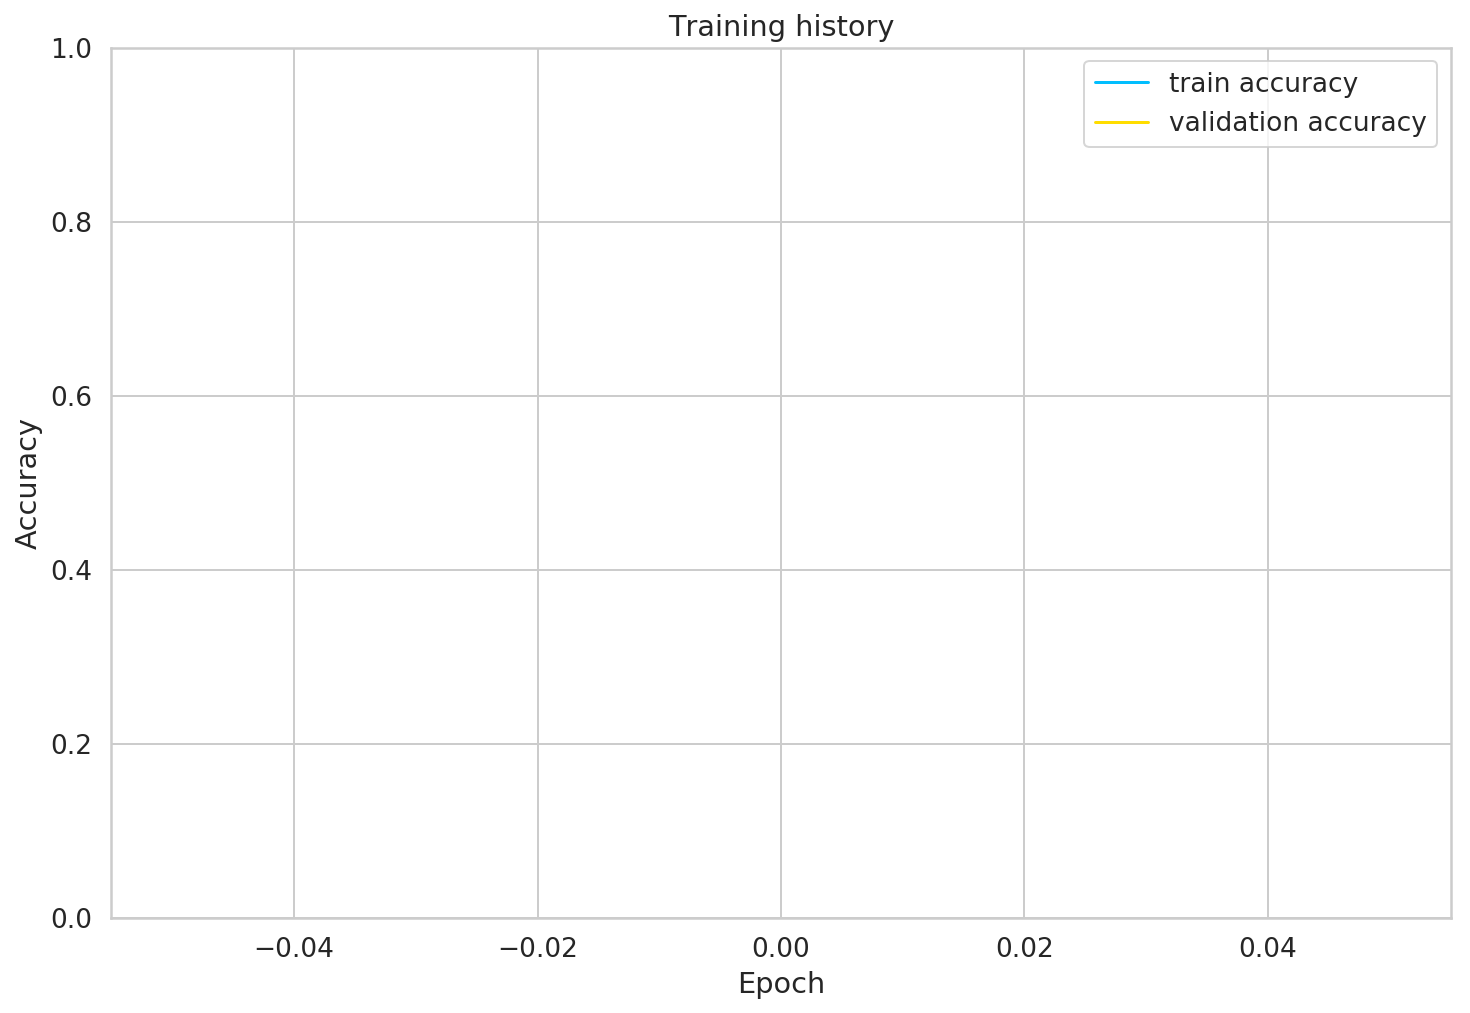

In [36]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [37]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [38]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.7043147208121827

In [39]:
def get_predictions(model, data_loader):
    model = model.eval()
  
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

        texts = d["review_text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        probs = F.softmax(outputs, dim=1)

        review_texts.extend(texts)
        predictions.extend(preds)
        prediction_probs.extend(probs)
        real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

IndentationError: expected an indented block (<ipython-input-39-e4397f6372b7>, line 12)

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

In [ ]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')